In [1]:
from models import vae_eucl_mnist, vae_hyp_mnist
import geoopt
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from hypmath import poincareball
from hypmath import metrics
import pandas as pd 
from tqdm import tqdm
import time
from torch.utils.tensorboard import SummaryWriter

#Disable Debugging APIs
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

#cuDNN Autotuner
torch.backends.cudnn.benchmark = True

In [2]:

transform = transforms.Compose([
        transforms.ToTensor(),
        ])

trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET',
                               download=True, train=True, transform=transform)
testset = datasets.MNIST('PATH_TO_STORE_TESTSET',
                            download=True, train=False, transform=transform)

size = len(trainset)
# print(size)

#Splitting training set into training and validation data
train_data, val_data = torch.utils.data.random_split(trainset, [int(size-size*0.2), int(size*0.2)])

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=6, pin_memory=True)
valloader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=True, num_workers=6, pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True, num_workers=6, pin_memory=True)


C:\Users\pc 3\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
### Training function
def train_epoch(vae, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader: 
        # Move tensor to the proper device
        # x = x.to(device)
        x_hat = vae(x)
        # Evaluate loss
        #ball = poincareball.PoincareBall()
        loss = ((x - x_hat)**2).sum() + (vae.encoder.kl)

        # Backward pass
        #optimizer.zero_grad()
        for param in model.parameters():
            param.grad = None
            
        loss.backward()
        optimizer.step()
        # Print batch loss
        #print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)


 ### Validation function
def val_epoch(vae, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x, _ in dataloader:
            # Move tensor to the proper device
            # x = x.to(device)
            # Encode data
            encoded_data = vae.encoder(x)
            # Decode data
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)  


def plot_ae_outputs(encoder,decoder,n):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = testset[i][0].unsqueeze(0)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   

### Model evaluation
def model_eval(model, epochs, trainloader, valloader, optimizer):
    tb = SummaryWriter()
    t_loss = []
    v_loss = []
    epoch_values = []

    for epoch in range(epochs):
        train_loss = train_epoch(model, trainloader, optimizer) 
        t_loss.append(train_loss)
        val_loss= val_epoch(model, valloader)
        v_loss.append(val_loss)
        epoch_values.append(epoch)
        
        tb.add_scalar("Training Loss", train_loss, epoch)
        tb.add_scalar("Validation Loss", val_loss, epoch)
        print("epoch:", epoch, "training loss:", train_loss, "validation loss:", val_loss)

        plot_ae_outputs(model.encoder, model.decoder,n=6)

    return t_loss, v_loss, epoch_values

VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (batch2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (linear1): Linear(in_features=288, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=4, bias=True)
    (linear3): Linear(in_features=128, out_features=4, bias=True)
  )
  (decoder): Decoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=288, bias=True)
      (3): ReLU(inplace=True)
    )
    (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
    (decoder_conv): Sequential(
      (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), bias=

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001FBFF94FCA0>
Traceback (most recent call last):
  File "C:\Users\pc 3\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\utils\data\dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "C:\Users\pc 3\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\utils\data\dataloader.py", line 1295, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


epoch: 0 training loss: 57.39245091756185 validation loss: 46.139728444417315


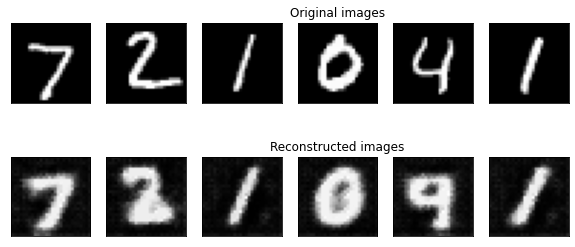

KeyboardInterrupt: 

In [10]:
latent_dims = 4
model = vae_eucl_mnist.VariationalAutoencoder(latent_dims)
#model = vae_hyp_mnist.VariationalAutoencoder(latent_dims)
torch.save(model.state_dict(), 'model.pt')
print(model)
learning_rate = 1e-3
epochs = 10
#optimizer = geoopt.optim.RiemannianAdam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
t_loss, v_loss, epoch_values = model_eval(model, epochs, trainloader, valloader, optimizer)

# for epoch in range(epochs):
#    train_loss = train_epoch(model, trainloader,optimizer)
#    val_loss = val_epoch(model, valloader)
#    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, epochs,train_loss,val_loss))
#    plot_ae_outputs(model.encoder, model.decoder,n=6)

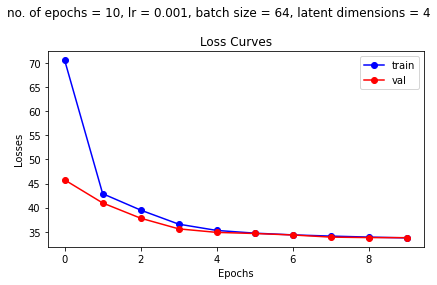

In [ ]:
fig , (ax0) = plt.subplots(1, 1)

# ax0 = fig.add_subplot(121, title="Loss curves")
# ax1 = fig.add_subplot(122, title="Accuracy curves")
ax0.set_title('Loss Curves')
ax0.plot(epoch_values, t_loss, 'bo-', label='train')
ax0.plot(epoch_values, v_loss, 'ro-', label='val')

ax0.set_xlabel('Epochs')
ax0.set_ylabel('Losses')
ax0.legend()

fig.suptitle('no. of epochs = {}, lr = {}, batch size = 64, latent dimensions = {}'.format(epochs, learning_rate, latent_dims))
fig.tight_layout()

In [ ]:
encoded_samples = []
for sample in tqdm(testset):
    img = sample[0].unsqueeze(0)
    label = sample[1]
    # Encode image
    model.eval()
    with torch.no_grad():
        encoded_img  = model.encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Latent Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
    
encoded_samples = pd.DataFrame(encoded_samples)
#print(encoded_samples)

from sklearn.manifold import TSNE
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score
import plotly.express as px

# #Davies-Bouldin Index
# db_index = davies_bouldin_score(encoded_samples, encoded_samples.label)
# print('Davies-Bouldin score :', db_index)

# #Calinski-Harabasz Index
# ch_score = calinski_harabasz_score(encoded_samples, encoded_samples.label)
# print('Calinski-Harabasz score:', ch_score)

#Silhouette Coefficient
#s_coeff = silhouette_score(encoded_samples, encoded_samples.label,  metric=metrics.PoincareDistance)
s_coeff = silhouette_score(encoded_samples, encoded_samples.label)
print('Silhouette score :',s_coeff)

px.scatter(encoded_samples, x='Latent Variable 0', y='Latent Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

100%|██████████| 10000/10000 [00:08<00:00, 1151.61it/s]


Silhouette score : 0.423487390100702


In [ ]:
#tsne = TSNE(n_components=2, metric=metrics.PoincareDistance)
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()

hyp: 0.44057081313189256
eucl: 0.423487390100702